In [166]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import display
from sklearn.metrics import mutual_info_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold
from sklearn.metrics import auc
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

In [24]:
df = pd.read_csv(r"D:\UNH Materials\ml-zoomcamp-2024\4. Evaluation\bank-full.csv", delimiter=";")

In [25]:
# filter dataframe columns
df = df[df.columns[~df.columns.isin(['default','loan'])]]

In [26]:
df.replace({'no':0, 'yes': 1}, inplace=True)
df

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,1,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,29,1,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,2,1,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,1506,1,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,1,0,unknown,5,may,198,1,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,825,0,cellular,17,nov,977,3,-1,0,unknown,1
45207,71,retired,divorced,primary,1729,0,cellular,17,nov,456,2,-1,0,unknown,1
45208,72,retired,married,secondary,5715,0,cellular,17,nov,1127,5,184,3,success,1
45209,57,blue-collar,married,secondary,668,0,telephone,17,nov,508,4,-1,0,unknown,0


In [27]:
train_full, test_df = train_test_split(df, test_size=0.2, random_state = 1)
train_df, val_df = train_test_split(train_full, test_size=0.25, random_state = 1)

In [28]:
y_train = train_df.y.values
y_val = val_df.y.values

del train_df['y']
del val_df['y']

## Q1 ROC AUC Feature Importance

In [49]:
cols = ['balance', 'day', 'duration', 'previous']
for col in cols:
    fpr, tpr, thresholds = roc_curve(y_train, train_df[col])
    ac = auc(fpr, tpr)
    print(ac)
#     if ac < 0.5:
#         fpr, tpr, thresholds = roc_curve(y_train, -train_df[col])
#         ac = auc(fpr, tpr)
#         print('new:', ac)

0.5888313805382317
0.474042117616092
0.8147002759670778
0.5985653242764153


Duration

## Q2 Question 2: Training the model

In [58]:
numerical = list(train_df.select_dtypes(include='int64').columns)
categorical = list(train_df.select_dtypes(include='object').columns)

In [102]:
dv = DictVectorizer(sparse=False)

train_dict = train_df[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [103]:
val_dict = val_df[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
# y_pred = (y_pred >= 0.5)
# (y_val == churn_decision).mean()

In [104]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
print(round(auc(fpr, tpr), 3))

0.9


## Q3

In [145]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [146]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

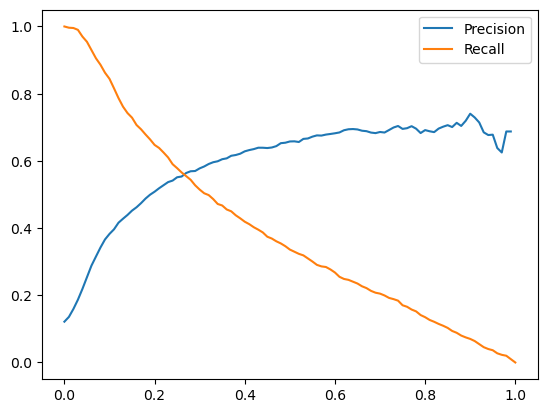

In [130]:
plt.plot(df_scores.threshold, df_scores['p'], label='Precision')
plt.plot(df_scores.threshold, df_scores['r'], label='Recall')
plt.legend()

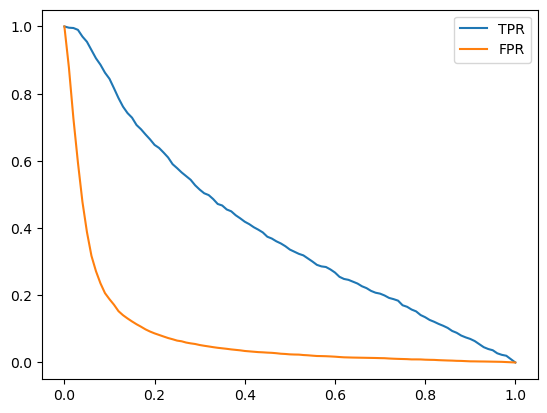

In [147]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

.265

## Q4 F1-Score

In [151]:
df_scores['f1'] = 2 * df_scores['p'] * df_scores['r'] / (df_scores['p'] + df_scores['r'])

In [152]:
df_scores[df_scores['f1'] == df_scores['f1'].max()]

,threshold,tp,fp,fn,tn,p,r,tpr,fpr,f1
21,0.21,701,651,397,7293,0.518491,0.638434,0.638434,0.081949,0.572245


In [153]:
df_scores.iloc[20:23, :]

,threshold,tp,fp,fn,tn,p,r,tpr,fpr,f1
20,0.20,711,688,387,7256,0.508220,0.647541,0.647541,0.086606,0.569483
21,0.21,701,651,397,7293,0.518491,0.638434,0.638434,0.081949,0.572245
22,0.22,686,614,412,7330,0.527692,0.624772,0.624772,0.077291,0.572143


.22

## Q5

In [164]:
def train(df_train, y_train, C):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [159]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [160]:
scores = []
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

In [162]:
for train_idx, val_idx in kfold.split(train_full):
    df_train = train_full.iloc[train_idx]
    df_val = train_full.iloc[val_idx]

    y_train = df_train.y.values
    y_val = df_val.y.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.906 +- 0.006


## Q6

In [167]:
n_splits = 5

for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(train_full):
        df_train = train_full.iloc[train_idx]
        df_val = train_full.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

 33%|████████████████████████████                                                        | 1/3 [00:07<00:14,  7.40s/it]

C=1e-06 0.701 +- 0.009


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:15<00:07,  7.77s/it]

C=0.001 0.862 +- 0.007


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:24<00:00,  8.24s/it]

C=1 0.906 +- 0.006
